In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression, PoissonRegressor
from sklearn.tree import DecisionTreeRegressor

import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from analysis import get_feature_importances, visualize_decision_trees, get_vif, wl_accuracy, season_record, runs_per_game

# Predicting baseball games

Using the data compiled from `baseball_data_collection.ipynb`, start training and testing the model. I will primarily be using the `RandomForestRegressor` model from scikit-learn, but other models are also shown for comparison purposes.

In [2]:
version = 6
df = pd.read_csv(f'./data/baseball/training/game_data_v{version}.csv')

### Processing the data

Split the game data for training and testing, either by seasons (2017-22 for training, 2023 for testing) or randomly. Also, drop any columns that should not be included in the model, such as team names.

In [3]:
# create the appropriate training and testing data based on home/away, dropping columns as needed
def create_data(drop_cols=['away_score', 'home_score', 'away_team', 'home_team'], y_col='away_score', split_by='random'):
    y = df[y_col]
    x = df.drop(drop_cols, axis=1)

    if split_by == 'season':
        x_train, x_test = x.iloc[0:13047], x.iloc[13047:]
        y_train, y_test = y.iloc[0:13047], y.iloc[13047:]
        # x_train, x_test = x.iloc[0:10617], x.iloc[10617:]
        # y_train, y_test = y.iloc[0:10617], y.iloc[10617:]
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True)
    
    return x_train, x_test, y_train, y_test

## Random forest regression

In [4]:
x_train_away, x_test_away, y_train_away, y_test_away = create_data(y_col='away_score', split_by='season')
x_train_home, x_test_home, y_train_home, y_test_home = create_data(y_col='home_score', split_by='season')

In [5]:
model_away = RandomForestRegressor(n_estimators=500, max_depth=5, max_features='sqrt')
model_home = RandomForestRegressor(n_estimators=500, max_depth=5, max_features='sqrt')

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=500)

In [6]:
pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

,away_pred,home_pred,away_true,home_true
count,2430.000000,2430.000000,2430.000000,2430.000000
mean,4.468096,4.592996,4.634979,4.596296
std,0.566120,0.469189,3.285711,3.150994
min,3.175977,3.386837,0.000000,0.000000
25%,4.058865,4.227478,2.000000,2.000000
50%,4.410532,4.537183,4.000000,4.000000
75%,4.840124,4.988363,6.000000,6.000000
max,6.809598,5.855892,25.000000,20.000000


In [7]:
print('RANDOM FOREST REGRESSION MODEL (v1)')

RANDOM FOREST REGRESSION MODEL (v1)


In [8]:
print(f'Accuracy: {wl_accuracy(results)}%')

Accuracy: 57.86008230452675%


In [9]:
season_record(df, results)

Season records:
ATL: 158-4	LAD: 150-12	HOU: 137-25	TB: 137-25	TOR: 135-27	
PHI: 133-29	SEA: 128-34	MIN: 125-37	MIL: 123-39	SD: 115-47	
SF: 110-52	NYY: 109-53	NYM: 92-70	TEX: 92-70	CHC: 87-75	
BAL: 73-89	BOS: 67-95	STL: 64-98	MIA: 63-99	CLE: 60-102	
DET: 54-108	LAA: 45-117	CIN: 39-123	AZ: 37-125	CWS: 29-133	
KC: 28-134	PIT: 19-143	WSH: 12-150	COL: 8-154	OAK: 1-161	


In [10]:
runs_per_game(df, results)

Runs scored per game:
ATL: 5.26 (852)	LAD: 5.1 (827)	HOU: 4.92 (798)	TOR: 4.79 (776)	PHI: 4.77 (772)	
SD: 4.76 (772)	MIN: 4.73 (766)	SEA: 4.7 (761)	MIL: 4.67 (756)	TB: 4.66 (755)	
TEX: 4.64 (752)	NYY: 4.61 (746)	STL: 4.6 (744)	SF: 4.58 (741)	CHC: 4.57 (741)	
NYM: 4.57 (740)	BAL: 4.49 (727)	BOS: 4.44 (720)	CLE: 4.44 (719)	MIA: 4.43 (718)	
LAA: 4.42 (716)	CIN: 4.41 (715)	DET: 4.35 (705)	AZ: 4.29 (695)	KC: 4.25 (688)	
CWS: 4.22 (683)	PIT: 4.15 (672)	WSH: 4.06 (658)	COL: 4.05 (656)	OAK: 3.99 (647)	


A random forest regressor with 500 decision trees and a maximum depth of 5 produces an accuracy of about 58%. This is great - most other models have an accuracy ranging from 55% to 60%. However, when I combine all the predicted outcomes and print the aggregate (i.e. the season win-loss record), the results appear to be extremely skewed. The Oakland Athletics (OAK), for instance, are predicted to lose almost every single game of the season. This can be partly explained by the low standard deviation of predicted runs scored, and one way to increase the variance is to decrease the number of decision trees (the `n_estimators` parameter) in the forest.

## Misc

In [24]:
# model_cv = GridSearchCV(estimator=MultiOutputRegressor(RandomForestRegressor()),
#                         param_grid={
#                             'estimator__n_estimators': [],
#                             'estimator__max_depth': [2, 4, 6, 8, 10],
#                         },
#                         # scoring={
#                         #     'accuracy': make_scorer(wl_accuracy),
#                         # },
#                         # refit='accuracy',
#                         cv=5)

Correlation coefficient (away team): r=0.21497074779894154
Correlation coefficient (home team): r=0.20828820312352855


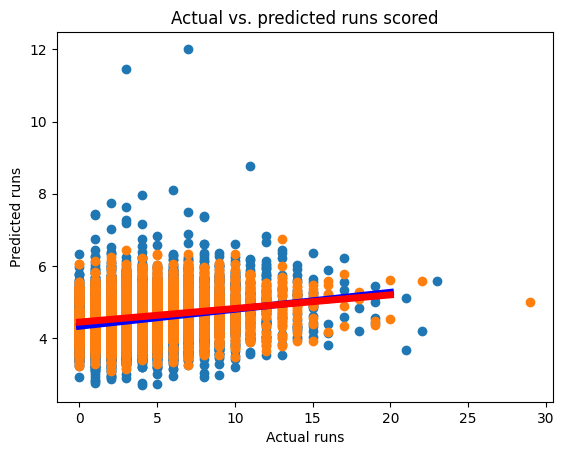

In [15]:
# # drawing a scatterplot with regression line
# # https://python-graph-gallery.com/scatterplot-with-regression-fit-in-matplotlib/

# plt.scatter(y_test['away_score'], pred_df[0])
# plt.scatter(y_test['home_score'], pred_df[1])


# m_away, b_away = np.polyfit(y_test['away_score'], pred_df[0], deg=1)
# x_away = np.linspace(0, 20, num=1000)

# plt.plot(x_away, m_away * x_away + b_away, color='b', lw=5)

# r_away = np.corrcoef(y_test['away_score'], pred_df[0])
# print(f'Correlation coefficient (away team): r={r_away[0][1]}')


# m_home, b_home = np.polyfit(y_test['home_score'], pred_df[1], deg=1)
# x_home = np.linspace(0, 20, num=1000)

# plt.plot(x_home, m_home * x_home + b_home, color='r', lw=5)

# r_home = np.corrcoef(y_test['home_score'], pred_df[1])
# print(f'Correlation coefficient (home team): r={r_home[0][1]}')


# plt.xlabel('Actual runs')
# plt.ylabel('Predicted runs')
# plt.title('Actual vs. predicted runs scored')

# plt.show()